In [3]:
import numpy as np
import pymongo
import pandas as pd
from scipy.stats import ks_2samp, describe, skew
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
import copy
import seaborn as sns
from scipy import stats
from ast import literal_eval
import random


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs
from pandas.plotting import parallel_coordinates
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler
from mpl_toolkits import mplot3d


import pdb

pd.options.display.max_columns = 500

/home/logan/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [15]:
"""To simplify our manual labeling we will simple sweep through a labeled word in the fake audio process (the 
fake acoustic core runs) searching for bigram we know should be in that word for that speakers. So that means we 
to augment the both dataset with word labels.

--> How do we handle one window overlapping 2 words...? (Ans: If at least half of window in word, we will treat it as 
                        being a part of that word.)
"""
#augment deepfake processed data with word labels
def add_words(df):
    fake_files = df.groupby(['filepath'])
    df_aug = []
    for key, grp in fake_files:
        #read associated WRD file
        tmp = convert_unix(key)
        df_wrds = pd.read_csv(tmp[:-3] + 'WRD', delimiter=' ', header=None, names=['start', 'end', 'word'])

        word_assignments = []
        #assign words to rows of the grp
        for _, row in grp.iterrows():
            #get middle div
            divide = (row.window_end - row.window_start) / 2 + row.window_start
            word = df_wrds[(df_wrds.start < divide) & (df_wrds.end > divide)]['word'].values
            if len(word) > 0:
                word = word[0]
            else:
                word = None
            word_assignments.append(word)
        grp['word'] = word_assignments 
        df_aug.append(grp)
    return pd.concat(df_aug, ignore_index=True)

def convert_unix(path):
    root_research = '/home/logan/drive/'
    return root_research + path.replace('\\', '/')[path.find('Research'):]

"""===============Augment data=====================
Function to augment/manipulate the data from the acoustic core 
in order to allow for the area distributions to be analyzed properly

"""

def augment(input_vals):
    #set up
    key, item = input_vals
    index_area = grouped_df.get_group(key)
    area_distros = pd.DataFrame(columns=['speaker_id', 'prev_index', 'sex', 'label', 'window', \
                                         'dimension', 'distro', 'word'])
    
    #get the area curves separately
    area_curves = index_area['cross_sect_est'].to_list()
    area_per_dim = list(zip(*area_curves))
    
    #add to new working df
    tmp = index_area['cross_sect_est'].tolist()
    tmp = list(zip(*tmp))
    new_row = {}
    new_row['speaker_id'] = index_area['speaker_id'].values[0]
    new_row['sex'] = index_area['sex'].values[0]
    new_row['label'] = index_area['label'].values[0]
    new_row['window'] = int(index_area['window_index'].values[0])
    new_row['prev_index'] = index_area.index[0]
    new_row['word'] = index_area['word'].values[0]
    new_row['filepath'] = index_area['filepath'].values[0]
    for index in range(0, len(tmp)):
        new_row['dimension'] = index
        new_row['distro'] = list(tmp[index])
        area_distros = area_distros.append(new_row, ignore_index=True)
    return area_distros

In [75]:
df_true = pd.read_csv('~/tmp/dumb.txt', sep=' ', names=['actual_data', 'classified_label', 'pos_count', 'neg_count'])
df_fake = pd.read_csv('~/tmp/dumb2.txt', sep=' ', names=['actual_data', 'classified_label', 'pos_count', 'neg_count'])
df_res = pd.concat([df_fake, df_true], ignore_index=True)
df_ideal = pd.DataFrame(ideal_set, columns=['label', 'feature', 'k', 'precision', 'recall'])

* df_true -- true bigram label counts
* df_fake -- fake bigram label counts
* df_res -- all bigram label counts
* df_ideal -- ideal bigram set

In [321]:
df_ideal.head(20)

,label,feature,k,precision,recall
0,aɪ -- l,feature_0,2.454771410797691,0.9210526315789473,1.0
1,aɪ -- l,feature_1,2.6749775220366576,0.9142857142857143,0.9142857142857143
2,aɪ -- m,feature_0,2.5711510051807824,0.9019607843137255,1.0
3,aɪ -- m,feature_1,1.1424760633930935,0.9019607843137255,1.0
4,b -- ɔ,feature_0,2.008231634161203,0.9032258064516129,1.0
5,b -- ɔ,feature_1,0.8383251525155656,0.9032258064516129,1.0
6,b -- ɔ,feature_2,0.9589533662288492,0.9032258064516129,1.0
7,b -- ɔ,feature_3,2.161530661616859,0.9285714285714286,0.9285714285714286
8,d -- oʊ,feature_0,2.7400175901495163,0.9090909090909091,1.0
9,d -- oʊ,feature_1,1.5658606454523196,0.9302325581395349,1.0


In [16]:
#read in timit data
#connect to mongoDB
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
db = myclient["exploration"]

table = db['timit_gentle_16']

#move mongo db over to pandas dataframe
cursor = table.find()
df = pd.DataFrame(list(cursor))
print('Creating timit train set')
df = df.drop(columns=['_id'])

"""
df_timit_train = augment_wrapper(df)
augment_wrapper throws an error everytime and I'm not sure
why, just copy nad pasting this here makes it work fine...
"""
#======Training===========
key_columns = ['speaker_id', 'sex', 'label', 'window_index']
df = add_words(df)
grouped_df = df.groupby(key_columns)

distros_list = []
print("Creating timit train...")
with Pool(4) as p:
    for x in tqdm(p.imap_unordered(augment, grouped_df), total=len(grouped_df),
                 position=0, leave=True):
        distros_list.append(x)
df_timit = pd.concat(distros_list)

Creating timit train set


/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating timit train...


100%|██████████| 36874/36874 [08:17<00:00, 74.19it/s]


In [29]:
label_occur = df_timit.groupby('label').agg('count').sort_values(by='speaker_id', ascending=False)[['speaker_id']]
label_occur = label_occur.rename(columns={'speaker_id': 'count'})

In [46]:
total_seen = label_occur.sum()
label_occur['percentage'] = label_occur.apply(lambda row: row['count'] / total_seen, axis=1)
top_50_percent = label_occur.head(106)

In [121]:
np.mean(df_ideal.groupby('label').agg('count')['feature'])

2.671641791044776

In [122]:
df_ideal

,label,feature,k,precision,recall
0,aɪ -- l,feature_0,2.454771410797691,0.9210526315789473,1.0
1,aɪ -- l,feature_1,2.6749775220366576,0.9142857142857143,0.9142857142857143
2,aɪ -- m,feature_0,2.5711510051807824,0.9019607843137255,1.0
3,aɪ -- m,feature_1,1.1424760633930935,0.9019607843137255,1.0
4,b -- ɔ,feature_0,2.008231634161203,0.9032258064516129,1.0
...,...,...,...,...,...
174,ʌ -- w,feature_1,0.9000284893258654,0.9047619047619048,1.0
175,ʌ -- w,feature_2,1.3381938473842492,0.9047619047619048,1.0
176,ʌ -- ʃ,feature_0,2.4394902451580838,0.9142857142857143,0.9411764705882353
177,ʌ -- ʃ,feature_1,1.4909711962388263,0.918918918918919,1.0


In [68]:
print('Total bigrams seen: ', label_occur.count()[0])
print("50% of the all bigrams occurrences are made up of the top 106 bigrams")
df_tmp = label_occur.reset_index()
df_tmp[df_tmp.label.isin(df_ideal.label.unique())].sum()

Total bigrams seen:  683
50% of the all bigrams occurrences are made up of the top 106 bigrams


label         ɔɪ -- lɔ -- td -- oʊk -- ɝk -- ɔɪ -- lk -- ɑm ...
count                                                     55950
percentage                                             0.101155
dtype: object

[]

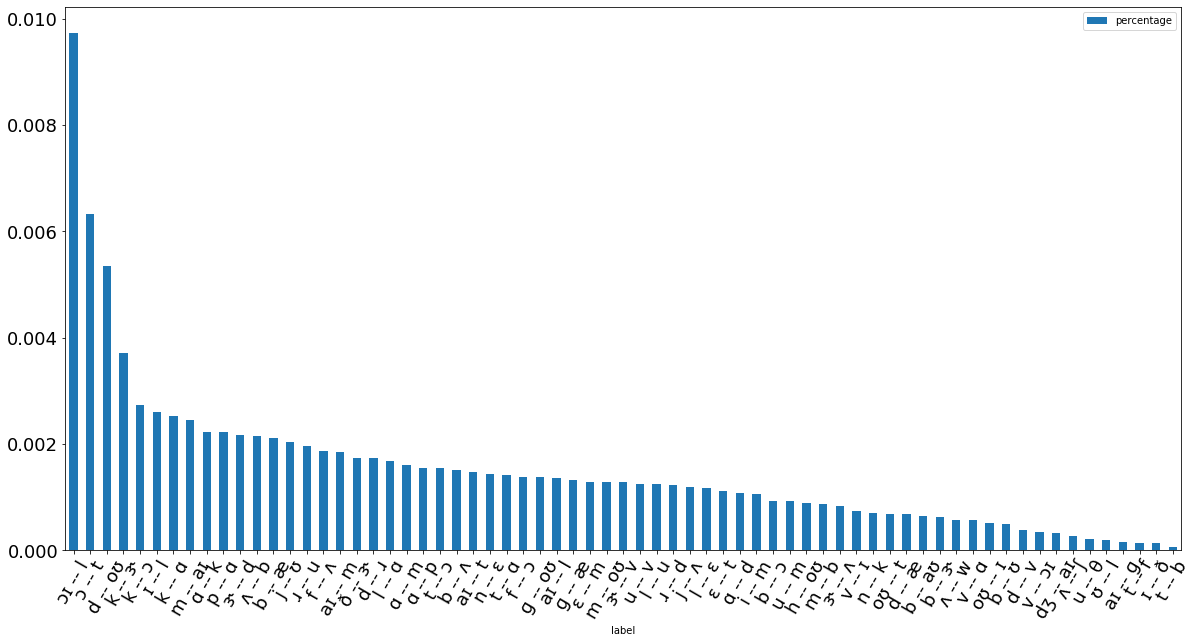

In [139]:
df_tmp = label_occur.reset_index()
df_tmp = df_tmp[df_tmp.label.isin(df_ideal.label.unique())]
df_tmp.plot(x='label', y='percentage', kind='bar', figsize=(20,10), fontsize=18)
#top_50_percent['percentage'].plot(kind='bar')
plt.xticks(rotation=60)
plt.plot()

In [149]:
label_occur = label_occur.reset_index()

In [211]:
label_occur

,label,count,percentage,dataset
0,s -- u,6150,0.011119,true
1,ɔɪ -- l,5385,0.009736,fake
2,ʃ -- i,5175,0.009356,true
3,ɹ -- æ,5100,0.009221,true
4,w -- ɑ,4830,0.008732,true
...,...,...,...,...
678,n -- n,30,0.000054,true
679,t -- b,30,0.000054,fake
680,b -- t,30,0.000054,true
681,p -- ʃ,30,0.000054,true


In [309]:
top_50 = label_occur[label_occur.dataset == 'true'].head(50)
fakes = label_occur[label_occur.dataset == 'fake']
top_50['dataset'] = '50 Most Common Bigrams'
fakes['dataset'] = 'Bigrams in Ideal Feature Set'
df_graph = pd.concat([top_50, fakes])
df_graph = df_graph.sort_values(by='percentage', ascending=False)

/home/logan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


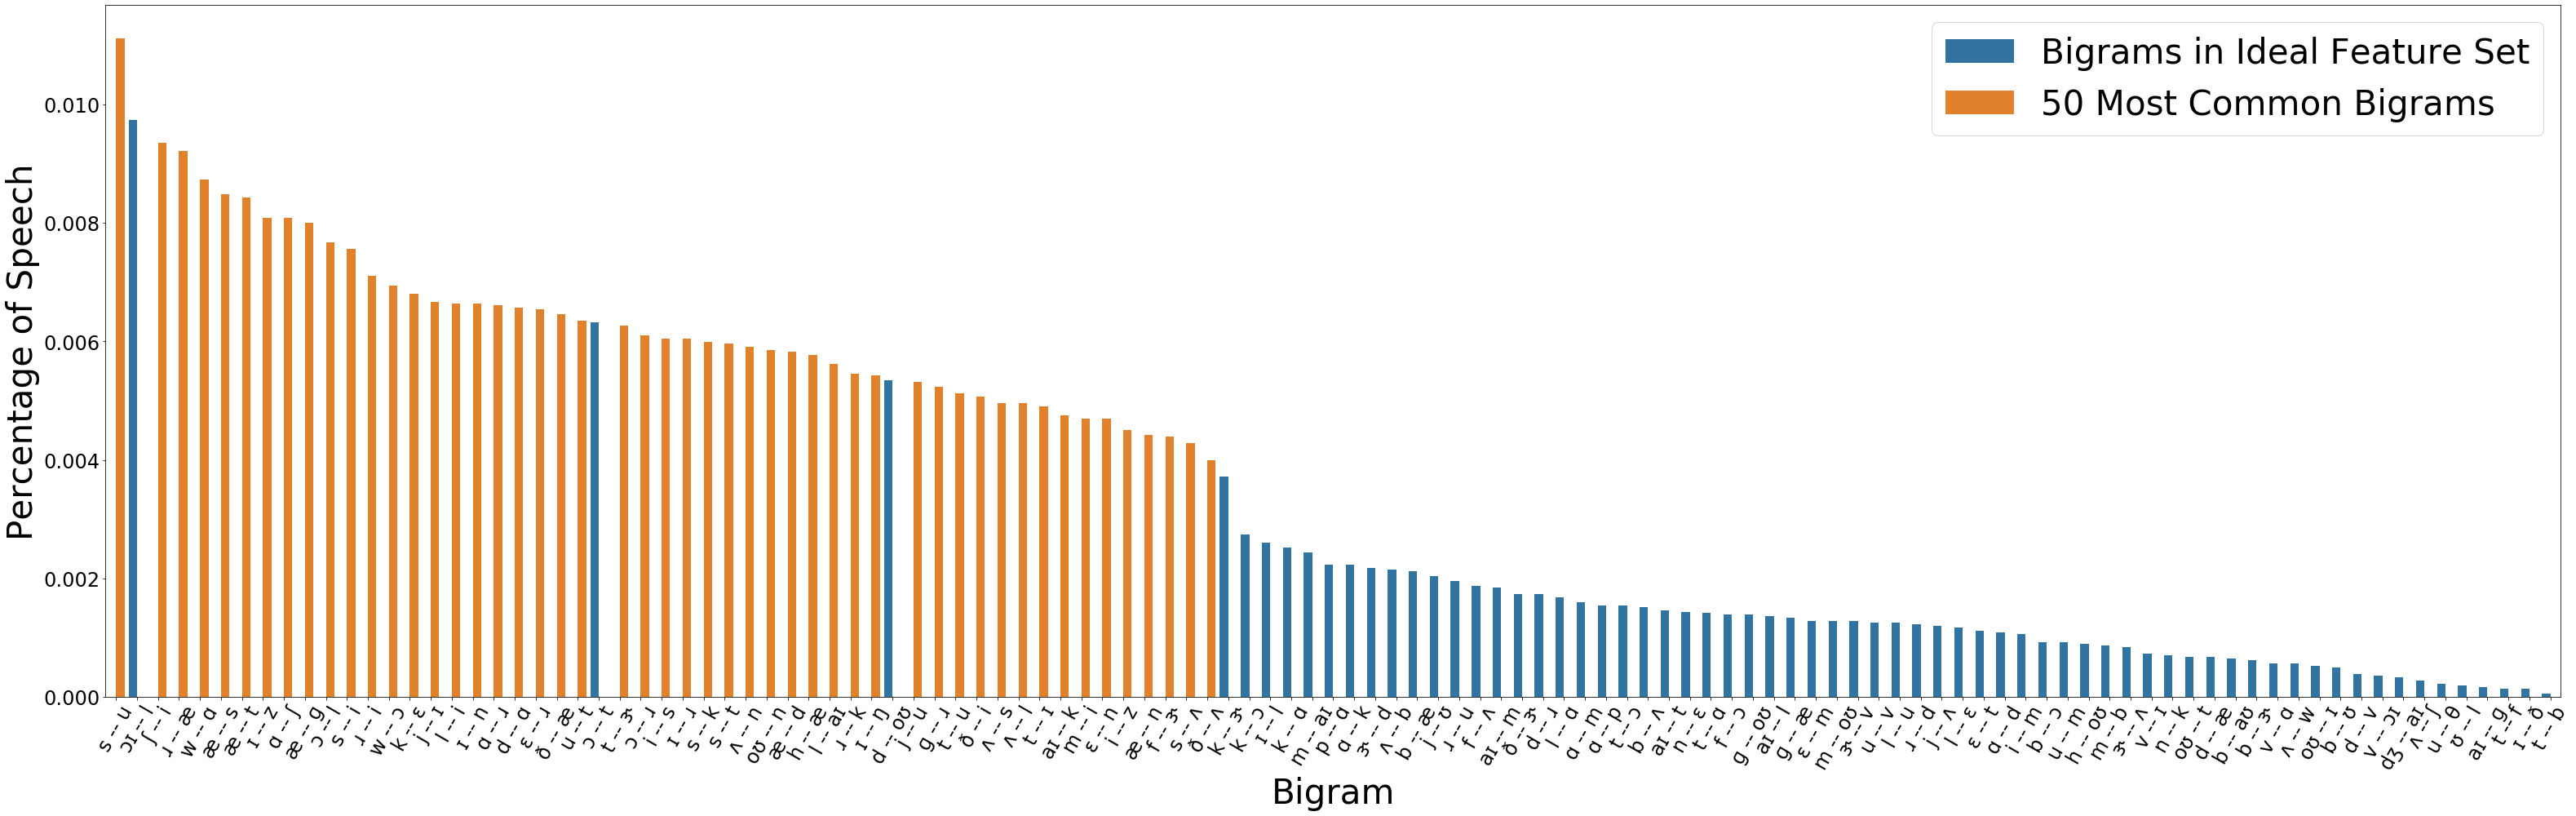

In [312]:
plt.figure(figsize=(44, 14))
sns.barplot(x='label', y='percentage', hue='dataset', hue_order=['Bigrams in Ideal Feature Set', \
                                                                 '50 Most Common Bigrams'], data=df_graph)
plt.xticks(rotation=60, fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc=1, fontsize=42)
plt.ylabel('Percentage of Speech', fontsize=42)
plt.xlabel('Bigram', fontsize=42)
plt.tight_layout()
plt.savefig('feature_spread.pdf')

In [298]:
df_res[['pos_count', 'neg_count']].sum()

pos_count    7518
neg_count    4585
dtype: int64

In [79]:
df_res['percent_flag'] = df_res.apply(lambda row: row['pos_count'] / (row['pos_count'] + row['neg_count']), axis=1)

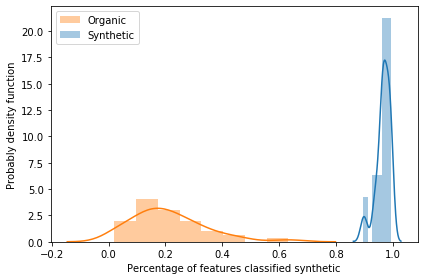

In [316]:
sns.distplot(df_res[df_res.actual_data == True]['percent_flag'], label='Organic', color='tab:orange')
sns.distplot(df_res[df_res.actual_data == 'fakes']['percent_flag'], label='Synthetic', color='tab:blue')
plt.legend()
plt.xlabel('Percentage of features classified synthetic')
plt.ylabel('Probably density function')
plt.tight_layout()
plt.savefig('kde_features.png')

In [234]:
df_sent_true = pd.read_hdf('true.hdf5', key = 'hadi')
df_sent_fakes = pd.read_hdf('fakes.hdf5', key = 'hadi')
df_sent = pd.concat([df_sent_true, df_sent_fakes], ignore_index=True)

In [235]:
df_sent

,original_label,our_label,ideal_feats,pos,neg
0,True,True,10,28,61
1,True,True,9,11,33
2,True,True,6,1,21
3,True,True,8,13,22
4,True,True,6,8,16
...,...,...,...,...,...
231,fakes,fakes,4,32,8
232,fakes,fakes,3,17,11
233,fakes,fakes,8,111,1
234,fakes,fakes,4,41,1


In [236]:
df_sent['percent_flag'] = df_sent.apply(lambda row: int(row['pos']) / (int(row['pos']) + int(row['neg'])), axis=1)

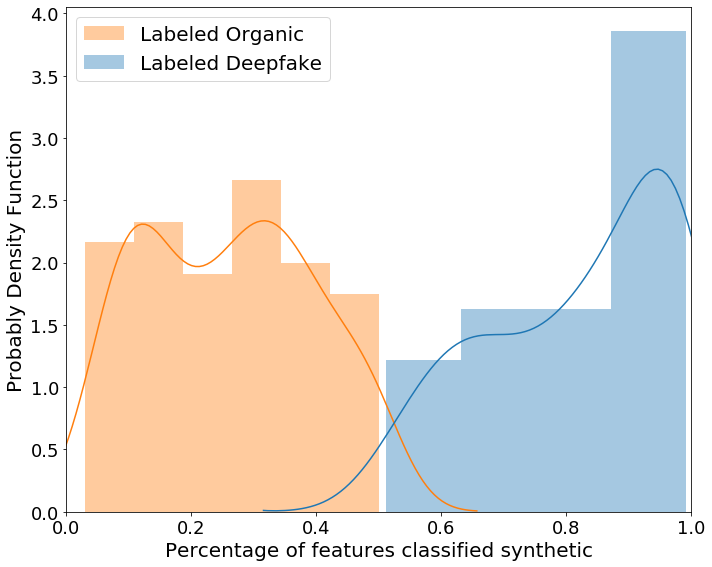

In [318]:
plt.figure(figsize=(10,8))
sns.distplot(df_sent[df_sent.our_label == 'True']['percent_flag'], label='Labeled Organic', color='tab:orange')
sns.distplot(df_sent[df_sent.our_label == 'fakes']['percent_flag'], label='Labeled Deepfake', color='tab:blue')
plt.legend(fontsize=20)
plt.xlabel('Percentage of features classified synthetic', fontsize=20)
plt.ylabel('Probably Density Function', fontsize=20)
plt.savefig('kde_features.png')
plt.xlim(0, 1)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('sentence_test.pdf')

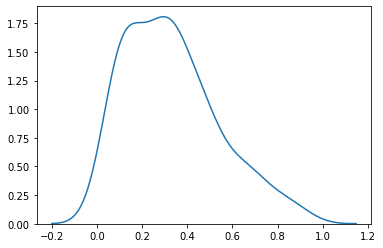

In [293]:
tmp = sns.kdeplot(df_sent[df_sent.original_label == 'True']['percent_flag'].values)

In [294]:
x, y = tmp.lines[0].get_data()

In [295]:
step_size = abs(x[0] - x[1])

In [296]:
np.sum([i * step_size for i in y if i < 0.5])

0.10620363096415901

In [ ]:
92.6% TPR

In [302]:
len(df_timit.label.unique())

683